## Stock Price Prediction

In [1]:
#Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing dataset

data = pd.read_csv("../input/nyse/prices-split-adjusted.csv")
df = pd.DataFrame(data)

In [3]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


### Data Information

In [4]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [5]:
# showing column wise %ge of NaN values they contains 

for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)


date 	-	 0.0
symbol 	-	 0.0
open 	-	 0.0
close 	-	 0.0
low 	-	 0.0
high 	-	 0.0
volume 	-	 0.0


> Since there is no null valus, we can move further 

<AxesSubplot:>

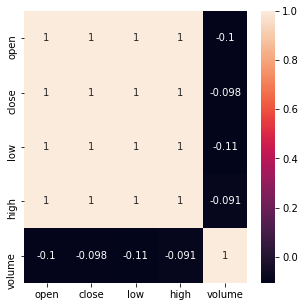

In [6]:
df = df[df['symbol']=='AAP']   # Choosin stock values for any company 

cormap = df.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cormap, annot = True)

In [7]:
def get_corelated_col(cor_dat, threshold): 
  # Cor_data to be column along which corelation to be measured 
  #Threshold be the value above which of corelation to considered
  feature=[]
  value=[]

  for i ,index in enumerate(cor_dat.index):
    if abs(cor_dat[index]) > threshold:
      feature.append(index)
      value.append(cor_dat[index])

  df = pd.DataFrame(data = value, index = feature, columns=['corr value'])
  return df


In [8]:
top_corelated_values = get_corelated_col(cormap['close'], 0.60)
top_corelated_values

,corr value
open,0.999382
close,1.000000
low,0.999615
high,0.999737


> Looks like all colums except _volume_ are ***highly co-related***. Using them for predictions.

In [9]:
df = df[top_corelated_values.index]
df.head()

,open,close,low,high
253,40.700001,40.380001,40.360001,41.040001
720,40.299999,40.139999,39.720001,40.310001
1188,40.049999,40.490002,40.049999,40.779999
1656,39.549999,40.480000,39.549999,40.540001
2124,40.250000,40.639999,40.110001,40.820000


In [10]:
df.shape

(1762, 4)

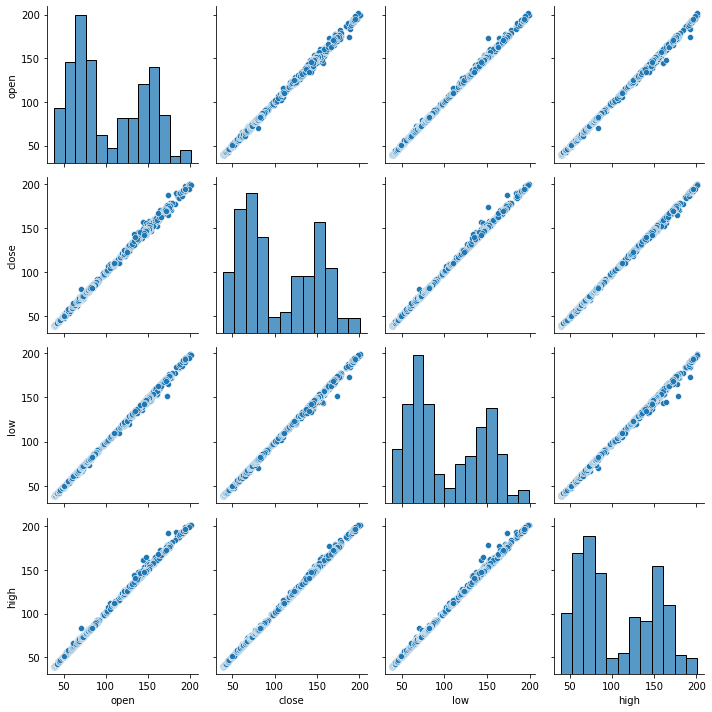

In [11]:
sns.pairplot(df)
plt.tight_layout()

> Since other parameters have linear relationship with __close__, we are using some linear models fore prediction

In [12]:
X = df.drop(['close'], axis=1)
y = df['close']

> Since range of data in different columns veries significantly we need to scale the independent variable i.e. X. For this we will use Min-Max Scaling.

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,open,low,high
0,0.012001,0.012392,0.010256
1,0.009539,0.008387,0.005746
2,0.008000,0.010452,0.008649
3,0.004923,0.007323,0.007167
4,0.009231,0.010827,0.008897


## Prediction Model

In [14]:
#now lets split data in test train pairs

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

Acc = []

### 1. Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression

# model training

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

LinearRegression()

In [16]:
# prediction
y_pred_1 = model_1.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1})
pred_df.head()

,Actual,Predicted
675111,173.660004,173.682489
675608,171.919998,172.593759
676105,172.000000,171.182789
676602,187.789993,187.980305
677099,187.029999,188.440838


In [17]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_1)))
Acc.append(r2_score(y_test, y_pred_1))

Accuracy score of the predictions: 0.9931342019332019


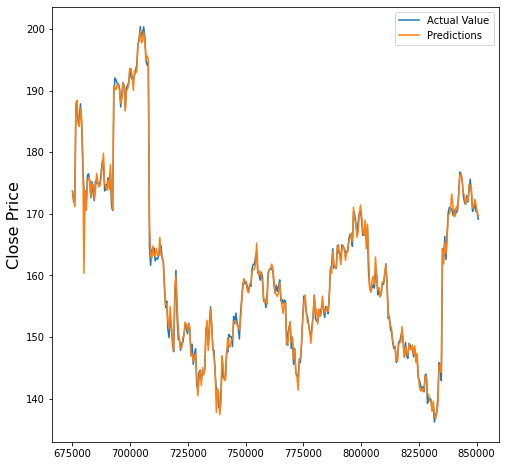

In [18]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

### 2. ANN

In [19]:
# Model Creation

from keras.models import Sequential
from keras.layers import Dense

def regressor(inp_dim):
    
    model = Sequential()
    
    model.add(Dense(20, input_dim=inp_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [20]:
# Model Training

model_2 = regressor(inp_dim=3)
model_2.fit(X_train, y_train, epochs=70, validation_split=0.2)

Epoch 1/70
36/36 [==============================] - 1s 14ms/step - loss: 6081.5518 - val_loss: 22085.0098
Epoch 2/70
36/36 [==============================] - 0s 3ms/step - loss: 6030.8916 - val_loss: 22000.4102
Epoch 3/70
36/36 [==============================] - 0s 3ms/step - loss: 6011.2013 - val_loss: 21586.6074
Epoch 4/70
36/36 [==============================] - 0s 3ms/step - loss: 5823.6767 - val_loss: 20221.5781
Epoch 5/70
36/36 [==============================] - 0s 3ms/step - loss: 5322.0593 - val_loss: 17011.8770
Epoch 6/70
36/36 [==============================] - 0s 3ms/step - loss: 4165.6553 - val_loss: 11525.0713
Epoch 7/70
36/36 [==============================] - 0s 3ms/step - loss: 2476.0902 - val_loss: 5151.7866
Epoch 8/70
36/36 [==============================] - 0s 3ms/step - loss: 768.1408 - val_loss: 1174.0548
Epoch 9/70
36/36 [==============================] - 0s 3ms/step - loss: 84.3737 - val_loss: 245.7488
Epoch 10/70
36/36 [==============================] - 0s 3ms/s

In [21]:
# Prediction

y_pred_2 = model_2.predict(X_test)

In [22]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2.flatten()})
pred_df.head()

,Actual,Predicted
675111,173.660004,174.153519
675608,171.919998,172.465057
676105,172.000000,170.682922
676602,187.789993,179.506378
677099,187.029999,188.215500


In [23]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_2)))
Acc.append(r2_score(y_test, y_pred_2))

Accuracy score of the predictions: 0.9877316090902418


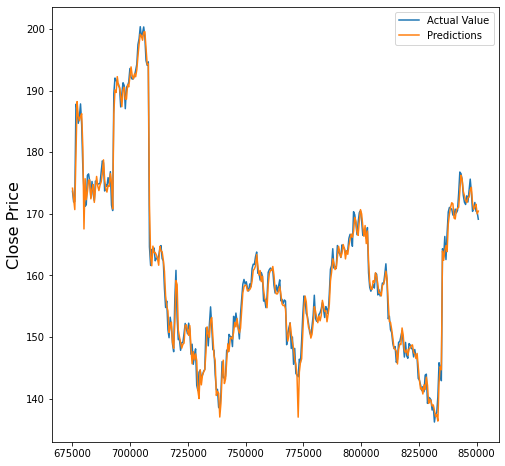

In [24]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

> Comparision of Accuracies of different models

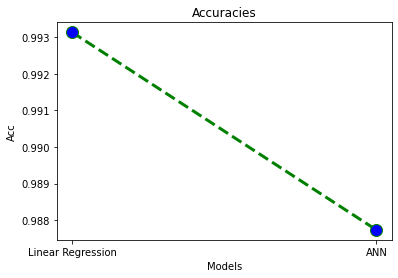

In [25]:
plt.plot(range(2), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(2), ['Linear Regression', 'ANN'])
plt.show()

**********************